In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import sys
import getopt
import errno

sys.path.insert(0,"/home/sunnycui/deepcell-tf")

import numpy as np

from skimage.measure import label
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from skimage.transform import resize

try:
    import scipy
    # scipy.linalg cannot be accessed until explicitly imported
    from scipy import linalg
    # scipy.ndimage cannot be accessed until explicitly imported
    from scipy import ndimage
except ImportError:
    scipy = None

from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


try:
    from tensorflow.python.keras.utils import conv_utils
except ImportError:  # tf v1.9 moves conv_utils from _impl to keras.utils
    from tensorflow.python.keras._impl.keras.utils import conv_utils

# Check if ImageDataGenerator is 1.11.0 or later
if not hasattr(ImageDataGenerator, 'apply_transform'):
    # tf.version is 1.10.0 or earlier, use keras_preprocessing classes
    from keras_preprocessing.image import Iterator
    from keras_preprocessing.image import ImageDataGenerator

from deepcell.utils.data_utils import sample_label_movie
from deepcell.utils.data_utils import sample_label_matrix
from deepcell.utils.transform_utils import deepcell_transform
from deepcell.utils.transform_utils import deepcell_flat_transform
from deepcell.utils.transform_utils import distance_transform_2d
from deepcell.utils.transform_utils import distance_transform_3d
from deepcell.utils.retinanet_anchor_utils import anchor_targets_bbox
from deepcell.utils.retinanet_anchor_utils import anchors_for_shape
from deepcell.utils.retinanet_anchor_utils import guess_shapes

/home/sunnycui/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sunnycui/deepcell-tf/deepcell/utils/__init__.py:48: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


# Transforms

In [2]:
def _transform_masks(y, transform, data_format=None, **kwargs):
    """Based on the transform key, apply a transform function to the masks.

    More detailed description. Caution for unknown transorm keys.

    Args:
        y: `labels` of ndim 4 or 5
        transform: one of {`deepcell`, `disc`, `watershed`, `centroid`, `None`}

    Returns:
        y_transform: the output of the given transform function on y

    Raises:
        IOError: An error occurred
    """
    valid_transforms = {'deepcell', 'deepcell_flat', 'disc', 'watershed', 'centroid', 'fgbg'}

    if data_format is None:
        data_format = K.image_data_format()

    if y.ndim not in {4, 5}:
        raise ValueError('`labels` data must be of ndim 4 or 5.  Got', y.ndim)

    channel_axis = 1 if data_format == 'channels_first' else -1

    if y.shape[channel_axis] != 1:
        raise ValueError('Expected channel axis to be 1 dimension. Got',
                         y.shape[1 if data_format == 'channels_first' else -1])

    if isinstance(transform, str):
        transform = transform.lower()
        if transform not in valid_transforms:
            raise ValueError('`{}` is not a valid transform'.format(transform))

    if transform == 'deepcell':
        dilation_radius = kwargs.pop('dilation_radius', None)
        y_transform = deepcell_transform(y, dilation_radius, data_format=data_format)

    elif transform == 'deepcell_flat':
        dilation_radius = kwargs.pop('dilation_radius', None)
        y_transform = deepcell_flat_transform(y, dilation_radius, data_format=data_format)

    elif transform == 'nuclei':
        # TODO
        dilation_radius = kwargs.pop('dilation_radius', None)
        y_transform = deepcell_flat_transform(y, dilation_radius, data_format=data_format)

    elif transform == 'watershed':
        distance_bins = kwargs.pop('distance_bins', 4)
        erosion = kwargs.pop('erosion_width', 0)

        if data_format == 'channels_first':
            y_transform = np.zeros((y.shape[0], *y.shape[2:]))
        else:
            y_transform = np.zeros(y.shape[0:-1])

        if y.ndim == 5:
            _distance_transform = distance_transform_3d
        else:
            _distance_transform = distance_transform_2d

        for batch in range(y_transform.shape[0]):
            if data_format == 'channels_first':
                mask = y[batch, 0, ...]
            else:
                mask = y[batch, ..., 0]

            y_transform[batch] = _distance_transform(
                mask, distance_bins, erosion)

        # convert to one hot notation
        y_transform = np.expand_dims(y_transform, axis=-1)
        y_transform = to_categorical(y_transform, num_classes=distance_bins)
        if data_format == 'channels_first':
            y_transform = np.rollaxis(y_transform, y.ndim - 1, 1)

    elif transform == 'disc':
        y_transform = to_categorical(y.squeeze(channel_axis))
        if data_format == 'channels_first':
            y_transform = np.rollaxis(y_transform, y.ndim - 1, 1)

    elif transform == 'fgbg':
        y_transform = np.where(y > 1, 1, y)
        # convert to one hot notation
        if data_format == 'channels_first':
            y_transform = np.rollaxis(y_transform, 1, y.ndim)
        y_transform = to_categorical(y_transform)
        if data_format == 'channels_first':
            y_transform = np.rollaxis(y_transform, y.ndim - 1, 1)

    elif transform is None:
        y_transform = y #.squeeze(channel_axis)
        if data_format == 'channels_first':
            y_transform = np.rollaxis(y_transform, y.ndim - 1, 1)

    elif transform == 'centroid':
        raise NotImplementedError('`centroid` transform has not been finished')

    return y_transform

# Define Stack Generator

In [22]:
class StackDataGenerator(ImageDataGenerator):
    """Generates batches of tensor image data with real-time data augmentation.
    The data will be looped over (in batches).
    Args:
        featurewise_center: boolean, set input mean to 0 over the dataset,
            feature-wise.
        samplewise_center: boolean, set each sample mean to 0.
        featurewise_std_normalization: boolean, divide inputs by std
            of the dataset, feature-wise.
        samplewise_std_normalization: boolean, divide each input by its std.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        zca_whitening: boolean, apply ZCA whitening.
        rotation_range: int, degree range for random rotations.
        width_shift_range: float, 1-D array-like or int
            float: fraction of total width, if < 1, or pixels if >= 1.
            1-D array-like: random elements from the array.
            int: integer number of pixels from interval
                `(-width_shift_range, +width_shift_range)`
            With `width_shift_range=2` possible values are ints [-1, 0, +1],
            same as with `width_shift_range=[-1, 0, +1]`,
            while with `width_shift_range=1.0` possible values are floats in
            the interval [-1.0, +1.0).
        shear_range: float, shear Intensity
            (Shear angle in counter-clockwise direction in degrees)
        zoom_range: float or [lower, upper], Range for random zoom.
            If a float, `[lower, upper] = [1-zoom_range, 1+zoom_range]`.
        channel_shift_range: float, range for random channel shifts.
        fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.
            Default is 'nearest'. Points outside the boundaries of the input
            are filled according to the given mode:
                'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                'nearest':  aaaaaaaa|abcd|dddddddd
                'reflect':  abcddcba|abcd|dcbaabcd
                'wrap':  abcdabcd|abcd|abcdabcd
        cval: float or int, value used for points outside the boundaries
            when `fill_mode = "constant"`.
        horizontal_flip: boolean, randomly flip inputs horizontally.
        vertical_flip: boolean, randomly flip inputs vertically.
        rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
            is applied, otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run after the image is resized and augmented.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: One of {"channels_first", "channels_last"}.
            "channels_last" mode means that the images should have shape
                `(samples, height, width, channels)`,
            "channels_first" mode means that the images should have shape
                `(samples, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
                Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
        validation_split: float, fraction of images reserved for validation
            (strictly between 0 and 1).
    """

    def __init__(self, **kwargs):
        super(StackDataGenerator, self).__init__(**kwargs)
        # Change the axes for 5D data
        if self.data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 3
            self.col_axis = 4
            self.time_axis = 2
        if self.data_format == 'channels_last':
            self.channel_axis = 4
            self.row_axis = 2
            self.col_axis = 3
            self.time_axis = 1

    def flow(self,
             train_dict,
             batch_size=1,
             frames_per_batch=61,
             skip=None,
             transform=None,
             transform_kwargs={},
             shuffle=True,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        """Generates batches of augmented/normalized data with given arrays.
        Args:
            train_dict: dictionary of X and y tensors. Both should be rank 5.
            frames_per_batch: int (default: 10).
                size of z axis in generated batches
            batch_size: int (default: 1).
            shuffle: boolean (default: True).
            seed: int (default: None).
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: str (default: `''`). Prefix to use for filenames of
                saved pictures (only relevant if `save_to_dir` is set).
            save_format: one of "png", "jpeg". Default: "png".
                (only relevant if `save_to_dir` is set)
        Returns:
            An Iterator yielding tuples of `(x, y)` where `x` is a numpy array
            of image data and `y` is a numpy array of labels of the same shape.
        """
        return StackArrayIterator(
            train_dict,
            self,
            batch_size=batch_size,
            frames_per_batch=frames_per_batch,
            skip=skip,
            transform=transform,
            transform_kwargs=transform_kwargs,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.
        Args:
            x: batch of inputs to be normalized.
        Returns:
            The normalized inputs.
        """
        # TODO: standardize each image, not all frames at once
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_axis = self.channel_axis - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_axis, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_axis, keepdims=True) + K.epsilon())

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                logging.warning('This ImageDataGenerator specifies '
                                '`featurewise_std_normalization`, but it '
                                'hasn\'t been fit on any training data. '
                                'Fit it first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + K.epsilon())
            else:
                logging.warning('This ImageDataGenerator specifies '
                                '`featurewise_std_normalization`, but it hasn\'t '
                                'been fit on any training data. Fit it '
                                'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                logging.warning('This ImageDataGenerator specifies '
                                '`zca_whitening`, but it hasn\'t '
                                'been fit on any training data. Fit it '
                                'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x, y=None, seed=None):
        """Applies a random transformation to an image.
        Args:
            x: 4D tensor, stack of images.
            y: 4D tensor, label mask for `x`, optional.
            seed: Random seed.
        Returns:
            A randomly transformed version of the input (same shape).
            If `y` is passed, it is transformed if necessary and returned.
        """
        # Note: Workaround to use self.apply_transform on our 4D tensor
        self.row_axis -= 1
        self.col_axis -= 1
        self.time_axis -= 1
        self.channel_axis -= 1
        x_new = np.empty(x.shape)
        if y is not None:
            y_new = np.empty(y.shape)
        # apply_transform expects ndim=3, but we are ndim=4
        for frame in range(x.shape[self.time_axis]):
            if self.data_format == 'channels_first':
                params = self.get_random_transform(x[:, frame].shape, seed)
                x_trans = self.apply_transform(x[:, frame], params)
                x_new[:, frame] = np.rollaxis(x_trans, -1, 0)
            else:
                params = self.get_random_transform(x[frame].shape, seed)
                x_new[frame] = self.apply_transform(x[frame], params)

            if y is not None:
                params['brightness'] = None
                params['channel_shift_intensity'] = None
                _interpolation_order = self.interpolation_order
                self.interpolation_order = 0
                if self.data_format == 'channels_first':
                    # y_trans = self.apply_transform(y[:, frame], params)
                    # y_new[:, frame] = np.rollaxis(y_trans, 1, 0)
                    y_trans = self.apply_transform(y, params)
                    y_new = np.rollaxis(y_trans, 1, 0)
                else:
                    # y_new[frame] = self.apply_transform(y[frame], params)
                    y_new = self.apply_transform(y, params)
                self.interpolation_order = _interpolation_order
        # Note: Undo workaround
        self.row_axis += 1
        self.col_axis += 1
        self.time_axis += 1
        self.channel_axis += 1
        if y is None:
            return x_new
        return x_new, y_new

    def fit(self, x, augment=False, rounds=1, seed=None):
        """Fits internal statistics to some sample data.
        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        Args:
            x: Numpy array, the data to fit on. Should have rank 5.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        Raises:
            ValueError: If input rank is not 5.
        """
        x = np.asarray(x, dtype=self.dtype)
        if x.ndim != 5:
            raise ValueError('Input to `.fit()` should have rank 5. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            logging.warning(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' +
                self.data_format + '" (channels on axis ' +
                str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' +
                str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' +
                str(x.shape) + ' (' + str(x.shape[self.channel_axis]) +
                ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(
                tuple([rounds * x.shape[0]] + list(x.shape)[1:]),
                dtype=self.dtype)
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            axis = (0, self.time_axis, self.row_axis, self.col_axis)
            self.mean = np.mean(x, axis=axis)
            broadcast_shape = [1, 1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            axis = (0, self.time_axis, self.row_axis, self.col_axis)
            self.std = np.std(x, axis=axis)
            broadcast_shape = [1, 1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            if scipy is None:
                raise ImportError('Using zca_whitening requires SciPy. '
                                  'Install SciPy.')
            flat_x = np.reshape(
                x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = scipy.linalg.svd(sigma)
            s_inv = 1. / np.sqrt(s[np.newaxis] + self.zca_epsilon)
            self.principal_components = (u * s_inv).dot(u.T)


# Stack Iterator

In [23]:
class StackArrayIterator(Iterator):
    """Iterator yielding data from two 5D Numpy arrays (`X and `y`).
    Args:
        train_dict: dictionary consisting of numpy arrays for `X` and `y`.
        movie_data_generator: Instance of `MovieDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        frames_per_batch: size of z axis in generated batches
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self,
                 train_dict,
                 movie_data_generator,
                 batch_size=1,
                 frames_per_batch=61,
                 skip=None,
                 transform=None,
                 transform_kwargs={},
                 shuffle=False,
                 seed=None,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        X, y = train_dict['X'], train_dict['y']
        if y is not None and X.shape[0] != y.shape[0]:
            raise ValueError('`X` (movie data) and `y` (labels) '
                             'should have the same size. Found '
                             'Found x.shape = {}, y.shape = {}'.format(
                                 X.shape, y.shape))

        self.channel_axis = 4 if data_format == 'channels_last' else 1
        self.time_axis = 1 if data_format == 'channels_last' else 2
        self.x = np.asarray(X, dtype=K.floatx())
        self.y = _transform_masks(y, transform, data_format=data_format, **transform_kwargs)

        if self.x.ndim != 5:
            raise ValueError('Input data in `MovieArrayIterator` '
                             'should have rank 5. You passed an array '
                             'with shape', self.x.shape)

        if self.x.shape[self.time_axis] - frames_per_batch < 0:
            raise ValueError(
                'The number of frames used in each training batch should '
                'be less than the number of frames in the training data!')

        self.frames_per_batch = frames_per_batch
        self.skip = skip
        self.movie_data_generator = movie_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(StackArrayIterator, self).__init__(
            len(self.y), batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        if self.data_format == 'channels_first':
            batch_x = np.zeros((len(index_array),
                                self.x.shape[1],
                                self.frames_per_batch,
                                self.x.shape[3],
                                self.x.shape[4]))
            # if self.y is not None:
                # batch_y = np.zeros((len(index_array),
                #                     self.y.shape[1],
                #                     self.frames_per_batch,
                #                     self.y.shape[3],
                #                     self.y.shape[4]))

        else:
            batch_x = np.zeros(tuple([len(index_array), self.frames_per_batch] +
                                     list(self.x.shape)[2:]))
        if self.y is not None:
            # batch_y = np.zeros(tuple([len(index_array), self.frames_per_batch] +
            #                          list(self.y.shape)[2:]))
            batch_y = np.zeros(tuple([len(index_array)] +
                                      list(self.y.shape)[1:]))

        for i, j in enumerate(index_array):
            if self.y is not None:
                y = self.y[j]

            # Sample along the time axis
#             last_frame = self.x.shape[self.time_axis] - self.frames_per_batch
#             time_start = np.random.randint(0, high=last_frame)
#             time_end = time_start + self.frames_per_batch
            
#             if self.time_axis == 1:
#                 x = self.x[j, time_start:time_end, ...]
#             elif self.time_axis == 2:
#                 x = self.x[j, :, time_start:time_end, ...]
            x = self.x[j, ...]
            if self.y is not None:
                y = self.y[j, ...]

            if self.y is not None:
                x, y = self.movie_data_generator.random_transform(
                    x.astype(K.floatx()), y=y)
                x = self.movie_data_generator.standardize(x)
                batch_y[i] = y
            else:
                x = self.movie_data_generator.random_transform(x.astype(K.floatx()))

            batch_x[i] = x

        if self.save_to_dir:
            time_axis = 2 if self.data_format == 'channels_first' else 1
            for i, j in enumerate(index_array):
                for frame in range(batch_x.shape[time_axis]):
                    if time_axis == 2:
                        img = array_to_img(batch_x[i, :, frame], self.data_format, scale=True)
                    else:
                        img = array_to_img(batch_x[i, frame], self.data_format, scale=True)
                    fname = '{prefix}_{index}_{hash}.{format}'.format(
                        prefix=self.save_prefix,
                        index=j,
                        hash=np.random.randint(1e4),
                        format=self.save_format)
                    img.save(os.path.join(self.save_to_dir, fname))

                    if self.y is not None:
                        # Save argmax of y batch
                        if self.time_axis == 2:
                            img_y = np.argmax(batch_y[i], axis=0)
                            img_channel_axis = 0
                            #img_y = batch_y[i, :, frame]
                        else:
                            img_channel_axis = -1
                        img_y = batch_y[i]
                        img_y = np.argmax(img_y, axis=img_channel_axis)
                        img_y = np.expand_dims(img_y, axis=img_channel_axis)
                        img = array_to_img(img_y, self.data_format, scale=True)
                        fname = 'y_{prefix}_{index}_{hash}.{format}'.format(
                            prefix=self.save_prefix,
                            index=j,
                            hash=np.random.randint(1e4),
                            format=self.save_format)
                        img.save(os.path.join(self.save_to_dir, fname))

        if self.y is None:
            return batch_x

        if self.skip is not None:
            batch_y = [batch_y] * (self.skip + 1)

        return batch_x, batch_y

    def next(self):
        """For python 2.x. Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)



# Test

In [5]:
from deepcell.utils import get_data

DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data')

filename = 'dapi_1.npz'
DATA_FILE = os.path.join(DATA_DIR, filename)

print("Loading data from " + filename)
train_dict, test_dict = get_data(DATA_FILE, mode='conv', test_size=0.1, seed=0)
print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

Loading data from dapi_1.npz
 -
X.shape: (680, 61, 256, 256, 1)
y.shape: (680, 256, 256, 1)


In [24]:
image_data_generator = StackDataGenerator(
       rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
       shear_range=0, # randomly shear images in the range (radians , -shear_range to shear_range)
       horizontal_flip=0,  # randomly flip images
       vertical_flip=0)

test_iterator = StackArrayIterator(train_dict, image_data_generator)
#test_iterator._get_track_ids()
(batch_x, batch_y) = test_iterator.next()
print("len(batch_x)", len(batch_x))
print("batch_x[0].shape:", batch_x[0].shape)
print("batch_y.shape:", batch_y.shape)

len(batch_x) 1
batch_x[0].shape: (61, 256, 256, 1)
batch_y.shape: (1, 256, 256, 1)


len(batch_x) 1
batch_x[0].shape: (61, 256, 256, 1)
batch_y.shape: (1, 256, 256, 1)


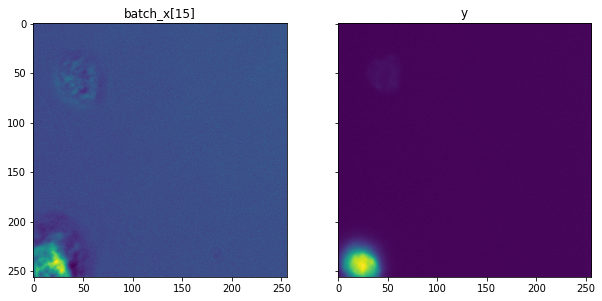

In [35]:
import matplotlib.pyplot as plt

(batch_x, batch_y) = test_iterator.next()
print("len(batch_x)", len(batch_x))
print("batch_x[0].shape:", batch_x[0].shape)
print("batch_y.shape:", batch_y.shape)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(batch_x[0][15,:,:,0])
ax[0].set_title('batch_x[%d]' %15)

ax[1].imshow(batch_y[0, ..., 0])
ax[1].set_title('y')
plt.show()